In [2]:
import os, importlib, sys, time, h5py

In [3]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags
import matplotlib.pyplot as plt

In [4]:
import ladyns as ldn
import ladyns.inference as inf

# 0. simulation from model + LFP

In [5]:
save_dir = "../temp/Appendix_C2"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## load data

In [6]:
data_dir = "../data/"
file_name = ['lfp_beta_1.mat']

In [7]:
data = [
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['v4_lfpb']
                    for fname in file_name], 0)[:,:,300::10].T,
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['pfc_lfpb']
                    for fname in file_name], 0)[:,:,300::10].T]

In [8]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[0]
obs_trial = data[0].shape[2]
rec_time = [0, 50]

## load LaDynS run on data

In [9]:
result_exp = np.load('../temp/Section_4/result.npz')
Sigma_exp = result_exp['Sigma_est']
weight_exp = result_exp['weight_est']

## cross precision

In [183]:
num_blobs = 3

In [184]:
times = np.array([[1, 1, 12], [21, 18, 6], [32, 37, 9]])

In [185]:
H0 = np.zeros((times.shape[0], num_time, num_time))
for i, (time_0, time_1, duration) in enumerate(times):
    H0[i, time_0:time_0+duration, time_1:time_1+duration] \
    = np.abs(np.arange(duration)-np.arange(duration)[:,None]) < 2

(0.0, 1.0, 0.0, 1.0)

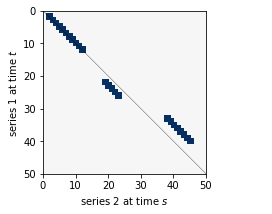

In [186]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(4,3))
gridspec.GridSpec(1,4); plt.subplot2grid((1,4), (0,0), colspan=3, rowspan=1)
ldn.imshow(np.sum(H0, 0), time=[0,50], identity=True, vmax=1)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
ax = plt.subplot2grid((1,4), (0,3))
ax.axis('off')

## latent direction

In [187]:
mu = [np.mean(dat, -1) for dat in data]
covs = [
    np.matmul(dat - m[...,None], dat - m[...,None], axes=[(1,2),(2,1),(1,2)])/obs_trial
    for dat, m in zip(data, mu)]

In [188]:
weights_exp = [np.array(weight_exp[:num_time]),
               np.array(weight_exp[num_time:])]
betas_exp = [(cov @ w[...,None])[...,0] for cov ,w in zip(covs, weights_exp)]

## latent precision

In [189]:
rhos = [0.148, 0.163]
precs_auto = [linalg.inv(
    np.exp(-np.square((np.arange(num_time)[:,None]-np.arange(num_time))*rho))
    + 1 * np.eye(num_time))
    for rho in rhos] 

In [190]:
snr = 0.4
prec_latent = np.array(np.block([
    [precs_auto[0]+snr*np.eye(num_time)*np.sum(H0,(0,2)), -snr*np.sum(H0,0)],
    [-snr*np.sum(H0,0).T, precs_auto[1]+snr*np.eye(num_time)*np.sum(H0,(0,1))]
]))

In [191]:
cov_latent = linalg.inv(prec_latent)
sd_latent = np.sqrt(np.diag(cov_latent))
corr_latent = cov_latent / sd_latent / sd_latent[:,None]
chol_latent = linalg.cholesky(corr_latent)

## simulate

In [192]:
obs_trial = data[0].shape[2]
num_trial = 1000

In [193]:
mchols = [np.array([linalg.cholesky(4*np.cov(dat_t, bias=True)) for dat_t in dat])
          for dat in data]

dummy = [dat[:,:,np.random.choice(obs_trial, num_trial, replace=True)]
         + np.matmul(mchol.transpose([0,2,1]), np.random.normal(size=(num_time,dim,num_trial)))
         for dat, dim, mchol in zip(data, dims, mchols)]
ldummy = [np.squeeze(np.matmul(dir_i[:,None,:], dumm - np.mean(dumm, -1, keepdims=True)))
          for dir_i, dumm in zip(weights_exp, dummy)]

cov_ldummy = np.cov(ldummy[0], ldummy[1])
sd_ldummy = np.sqrt(np.diag(cov_ldummy))

latent_variables = (chol_latent.T @ np.random.normal(0, 1, (2*num_time, num_trial)))

pops = [dummy[0] + betas_exp[0][:,:,None] * (sd_ldummy[:num_time,None,None]*latent_variables[:num_time,None,:]-ldummy[0][:,None,:]),
        dummy[1] + betas_exp[1][:,:,None] * (sd_ldummy[num_time:,None,None]*latent_variables[num_time:,None,:]-ldummy[1][:,None,:])]

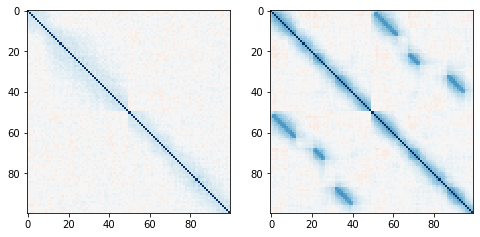

In [194]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); ldn.imshow(np.corrcoef(ldummy[0],ldummy[1]))
plt.subplot(1,2,2); ldn.imshow(np.corrcoef(latent_variables))

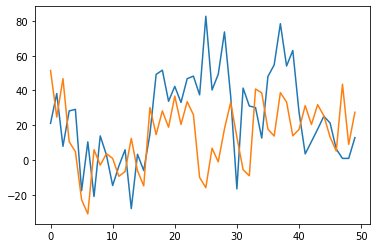

In [199]:
plt.plot(pops[0][:,0,0])
plt.plot(pops[1][:,0,0])

# 1. parameter calibration

In [200]:
offset_cross = 10
offset_auto = 10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.2), np.log(0.002), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.full((11,), 0), ## lambdas_auto
    np.full((11,), 0), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [201]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [202]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

In [203]:
num_cv = 10

In [31]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    pops_bst = [pops[0], pops[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(pops_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 64.855974, change: 0.119154, lapse: 0.329010
2-th iter, nll: 63.767722, change: 0.095820, lapse: 0.354352
3-th iter, nll: 63.655249, change: 0.024429, lapse: 0.331713
4-th iter, nll: 63.636994, change: 0.006724, lapse: 0.305634
5-th iter, nll: 63.633664, change: 0.003012, lapse: 0.296733
6-th iter, nll: 63.633023, change: 0.001348, lapse: 0.271880
7-th iter, nll: 63.632895, change: 0.000603, lapse: 0.255416
1-th iter, nll: 63.632869, change: 0.000271, lapse: 0.245632
1-th iter, nll: 63.632568, change: 0.012963, lapse: 0.226164
2-th iter, nll: 63.632563, change: 0.000755, lapse: 0.231065
1-th iter, nll: 63.615003, change: 0.029576, lapse: 0.268299
2-th iter, nll: 63.614782, change: 0.003257, lapse: 0.260719
3-th iter, nll: 63.614759, change: 0.000815, lapse: 0.236877
1-th iter, nll: 63.549075, change: 0.020789, lapse: 0.298326
2-th iter, nll: 63.548427, change: 0.003206, lapse: 0.274831
3-th iter, nll: 63.548359, change: 0.000967, lapse: 0.248044
1-th iter, nll: 63.42923

3-th iter, nll: 63.400607, change: 0.001658, lapse: 0.286338
4-th iter, nll: 63.400506, change: 0.000560, lapse: 0.263229
1-th iter, nll: 63.239382, change: 0.118926, lapse: 0.358027
2-th iter, nll: 63.226966, change: 0.007549, lapse: 0.307026
3-th iter, nll: 63.225580, change: 0.002093, lapse: 0.286563
4-th iter, nll: 63.225341, change: 0.000914, lapse: 0.280921
1-th iter, nll: 63.054948, change: 0.128845, lapse: 0.367440
2-th iter, nll: 63.033936, change: 0.008741, lapse: 0.321138
3-th iter, nll: 63.031526, change: 0.002827, lapse: 0.296364
4-th iter, nll: 63.031099, change: 0.001311, lapse: 0.278632
5-th iter, nll: 63.031007, change: 0.000627, lapse: 0.261588
1-th iter, nll: 62.891444, change: 0.134916, lapse: 0.365009
2-th iter, nll: 62.861276, change: 0.010019, lapse: 0.336939
3-th iter, nll: 62.857702, change: 0.003374, lapse: 0.347403
4-th iter, nll: 62.857046, change: 0.001708, lapse: 0.310537
5-th iter, nll: 62.856899, change: 0.000815, lapse: 0.258490
1-th iter, nll: 62.76448

2-th iter, nll: 63.086059, change: 0.013379, lapse: 0.305923
3-th iter, nll: 63.083614, change: 0.003827, lapse: 0.279886
4-th iter, nll: 63.083157, change: 0.001459, lapse: 0.263898
5-th iter, nll: 63.083055, change: 0.000693, lapse: 0.245797
1-th iter, nll: 62.959434, change: 0.136574, lapse: 0.348282
2-th iter, nll: 62.931147, change: 0.014042, lapse: 0.319068
3-th iter, nll: 62.927677, change: 0.004082, lapse: 0.291105
4-th iter, nll: 62.927014, change: 0.001746, lapse: 0.263006
5-th iter, nll: 62.926863, change: 0.000838, lapse: 0.247717
1-th iter, nll: 62.844808, change: 0.138140, lapse: 0.358280
2-th iter, nll: 62.810196, change: 0.014396, lapse: 0.327263
3-th iter, nll: 62.805883, change: 0.004254, lapse: 0.296500
4-th iter, nll: 62.805054, change: 0.001877, lapse: 0.279319
5-th iter, nll: 62.804864, change: 0.000934, lapse: 0.252860
1-th iter, nll: 62.762417, change: 0.140997, lapse: 0.364958
2-th iter, nll: 62.722997, change: 0.014663, lapse: 0.331368
3-th iter, nll: 62.71806

2-th iter, nll: 62.829349, change: 0.013655, lapse: 0.318112
3-th iter, nll: 62.825471, change: 0.004310, lapse: 0.285896
4-th iter, nll: 62.824751, change: 0.002040, lapse: 0.266580
5-th iter, nll: 62.824591, change: 0.001001, lapse: 0.261060
6-th iter, nll: 62.824552, change: 0.000537, lapse: 0.246089
1-th iter, nll: 62.780079, change: 0.131828, lapse: 0.378948
2-th iter, nll: 62.740284, change: 0.014223, lapse: 0.325045
3-th iter, nll: 62.735707, change: 0.004653, lapse: 0.300194
4-th iter, nll: 62.734845, change: 0.002215, lapse: 0.272345
5-th iter, nll: 62.734650, change: 0.001096, lapse: 0.265153
6-th iter, nll: 62.734602, change: 0.000630, lapse: 0.249807
10-th cv finished, lapse: 11.796sec.


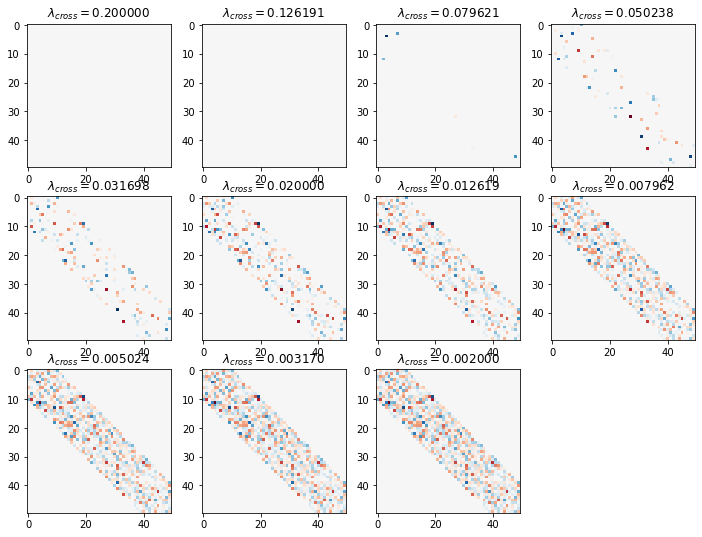

In [32]:
plt.figure(figsize=(12,3*np.ceil(lambdas.shape[-1]/4)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(np.ceil(lambdas.shape[-1]/4), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [33]:
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

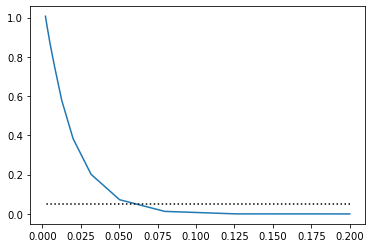

In [34]:
plt.plot(lambdas[0], fdrs_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05), color='black', linestyle=':')

# cv result

In [35]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [36]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.07962143411069945, 0.0, 0.0, 0.0)

In [37]:
lambda_graph = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

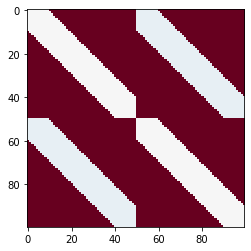

In [38]:
ldn.imshow(lambda_graph)

In [205]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(pops, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, verbose=True,
            weight_init = weight_init)

1-th iter, nll: 74.267466, change: 0.113134, lapse: 0.260887
2-th iter, nll: 65.006810, change: 0.347347, lapse: 0.336385
3-th iter, nll: 61.461365, change: 0.306946, lapse: 0.352097
4-th iter, nll: 60.438150, change: 0.221157, lapse: 0.335246
5-th iter, nll: 59.991792, change: 0.257107, lapse: 0.327851
6-th iter, nll: 59.691184, change: 0.259776, lapse: 0.319106
7-th iter, nll: 59.635583, change: 0.089628, lapse: 0.289472
8-th iter, nll: 59.627221, change: 0.026015, lapse: 0.275392
9-th iter, nll: 59.625576, change: 0.007262, lapse: 0.267225
10-th iter, nll: 59.625244, change: 0.002680, lapse: 0.253419
11-th iter, nll: 59.625177, change: 0.001312, lapse: 0.240405
12-th iter, nll: 59.625164, change: 0.000614, lapse: 0.225661


## plots

Text(0.5, 0, 'series 2 at time $s$')

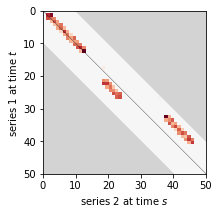

In [248]:
plt.figure(figsize=(3,3))
ldn.imshow(Omega_est[:num_time,num_time:], time=[0,50], identity=True, vmax=0.4)
plt.fill_between((10, 50), (0, 0), (0,40), color='lightgrey')
plt.fill_between((0, 40), (10, 50), (50,50), color='lightgrey')
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
# plt.clim(-0.1,0.1); cbar = plt.colorbar(ticks=[-0.1, -0.05, 0.0, 0.05, 0.1])
# cbar.ax.set_yticklabels(['< -0.10','-0.05','0.00','0.05','> 0.10'])

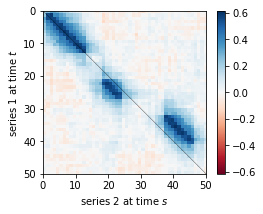

In [212]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_est[:num_time,num_time:], time=[0,50], identity=True)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
plt.colorbar()

# 2. bootstrap test

In [122]:
num_perm = 2000

In [123]:
init_arg = {'Omega_init': Omegas_cv[0,id_cv],
            'weight_init': weights_cv[id_cv]}

In [124]:
Omegas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])
Sigmas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])

for iter_perm in range(num_perm):    
    while True:
        with np.errstate(all='raise'):
            try:
                start_perm = time.time()
                
                # random sample
                trial_sample = np.random.choice(num_trial, num_trial, False)
                pops_bst = [pops[0], pops[1][:,:,trial_sample]]

                # permutation
                Omega_perm, Sigma_perm, latent_perm, weight_perm \
                = ldn.fit(pops_bst, lambda_diag, lambda_cross, offset_cross,
                          lambda_auto, offset_auto, 
                          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                          **init_arg)
        
                
            except FloatingPointError:
                sys.__stdout__.write("%d-th permutation encountered FloatingPointError, lapse:%.3fsec.\n"
                                     %(iter_perm+1, time.time()-start_perm))
                sys.__stdout__.write("Retrying...\n")
                sys.__stdout__.flush()
                continue
                
            init_arg = {'Omega_init':Omega_perm, 'weight_init':weight_perm}
                        
            # save result
            Omegas_perm[iter_perm] = Omega_perm
            Sigmas_perm[iter_perm] = Sigma_perm
            
            sys.__stdout__.write("%d-th permutation finished, lapse: %.3fsec.\n"
                          %(iter_perm+1, time.time()-start_perm))
            sys.__stdout__.flush()
            break

1-th iter, nll: 63.631204, change: 0.026169, lapse: 0.165130
2-th iter, nll: 63.631184, change: 0.001725, lapse: 0.163571
3-th iter, nll: 63.631182, change: 0.000306, lapse: 0.166254
1-th permutation finished, lapse: 0.517sec.
1-th iter, nll: 63.631154, change: 0.032435, lapse: 0.155988
2-th iter, nll: 63.631107, change: 0.002846, lapse: 0.168288
3-th iter, nll: 63.631101, change: 0.000651, lapse: 0.157683
2-th permutation finished, lapse: 0.502sec.
1-th iter, nll: 63.631845, change: 0.032702, lapse: 0.164134
2-th iter, nll: 63.631807, change: 0.002182, lapse: 0.166381
3-th iter, nll: 63.631803, change: 0.000399, lapse: 0.156132
3-th permutation finished, lapse: 0.507sec.
1-th iter, nll: 63.630904, change: 0.030193, lapse: 0.166765
2-th iter, nll: 63.630872, change: 0.002845, lapse: 0.161816
3-th iter, nll: 63.630869, change: 0.000521, lapse: 0.149130
4-th permutation finished, lapse: 0.497sec.
1-th iter, nll: 63.629513, change: 0.040635, lapse: 0.178982
2-th iter, nll: 63.629469, chan

2-th iter, nll: 63.631309, change: 0.002259, lapse: 0.184420
3-th iter, nll: 63.631305, change: 0.000492, lapse: 0.166061
38-th permutation finished, lapse: 0.552sec.
1-th iter, nll: 63.631947, change: 0.026564, lapse: 0.187070
2-th iter, nll: 63.631923, change: 0.001303, lapse: 0.175063
3-th iter, nll: 63.631920, change: 0.000270, lapse: 0.160694
39-th permutation finished, lapse: 0.544sec.
1-th iter, nll: 63.630973, change: 0.028040, lapse: 0.161609
2-th iter, nll: 63.630942, change: 0.002681, lapse: 0.173192
3-th iter, nll: 63.630939, change: 0.000619, lapse: 0.156211
40-th permutation finished, lapse: 0.512sec.
1-th iter, nll: 63.630277, change: 0.035821, lapse: 0.163871
2-th iter, nll: 63.630225, change: 0.003452, lapse: 0.180296
3-th iter, nll: 63.630221, change: 0.000618, lapse: 0.167865
41-th permutation finished, lapse: 0.533sec.
1-th iter, nll: 63.630573, change: 0.039214, lapse: 0.171489
2-th iter, nll: 63.630531, change: 0.001748, lapse: 0.175366
3-th iter, nll: 63.630526, 

2-th iter, nll: 63.632090, change: 0.001487, lapse: 0.163580
3-th iter, nll: 63.632086, change: 0.000249, lapse: 0.135396
76-th permutation finished, lapse: 0.469sec.
1-th iter, nll: 63.631183, change: 0.030881, lapse: 0.155318
2-th iter, nll: 63.631161, change: 0.001630, lapse: 0.146571
3-th iter, nll: 63.631159, change: 0.000267, lapse: 0.138648
77-th permutation finished, lapse: 0.459sec.
1-th iter, nll: 63.631052, change: 0.036033, lapse: 0.151321
2-th iter, nll: 63.631014, change: 0.002103, lapse: 0.261533
3-th iter, nll: 63.631010, change: 0.000623, lapse: 0.231771
78-th permutation finished, lapse: 0.664sec.
1-th iter, nll: 63.632500, change: 0.025683, lapse: 0.205378
2-th iter, nll: 63.632482, change: 0.000886, lapse: 0.156005
79-th permutation finished, lapse: 0.386sec.
1-th iter, nll: 63.631699, change: 0.019925, lapse: 0.146553
2-th iter, nll: 63.631685, change: 0.001025, lapse: 0.146634
3-th iter, nll: 63.631684, change: 0.000201, lapse: 0.127764
80-th permutation finished,

2-th iter, nll: 63.631873, change: 0.001193, lapse: 0.146864
3-th iter, nll: 63.631872, change: 0.000235, lapse: 0.135118
112-th permutation finished, lapse: 0.452sec.
1-th iter, nll: 63.630562, change: 0.035996, lapse: 0.171204
2-th iter, nll: 63.630526, change: 0.002552, lapse: 0.162466
3-th iter, nll: 63.630521, change: 0.000504, lapse: 0.146715
113-th permutation finished, lapse: 0.499sec.
1-th iter, nll: 63.632075, change: 0.041428, lapse: 0.159740
2-th iter, nll: 63.632040, change: 0.001765, lapse: 0.162536
3-th iter, nll: 63.632036, change: 0.000342, lapse: 0.143446
114-th permutation finished, lapse: 0.484sec.
1-th iter, nll: 63.632330, change: 0.019702, lapse: 0.147059
2-th iter, nll: 63.632315, change: 0.001238, lapse: 0.154907
3-th iter, nll: 63.632313, change: 0.000240, lapse: 0.147135
115-th permutation finished, lapse: 0.468sec.
1-th iter, nll: 63.630401, change: 0.030372, lapse: 0.151631
2-th iter, nll: 63.630376, change: 0.001916, lapse: 0.154679
3-th iter, nll: 63.6303

2-th iter, nll: 63.628452, change: 0.002755, lapse: 0.155808
3-th iter, nll: 63.628446, change: 0.000398, lapse: 0.144317
150-th permutation finished, lapse: 0.480sec.
1-th iter, nll: 63.632468, change: 0.041200, lapse: 0.156393
2-th iter, nll: 63.632443, change: 0.000658, lapse: 0.155808
151-th permutation finished, lapse: 0.330sec.
1-th iter, nll: 63.631078, change: 0.029820, lapse: 0.153567
2-th iter, nll: 63.631045, change: 0.003070, lapse: 0.160744
3-th iter, nll: 63.631041, change: 0.000634, lapse: 0.144671
152-th permutation finished, lapse: 0.478sec.
1-th iter, nll: 63.630706, change: 0.033953, lapse: 0.155289
2-th iter, nll: 63.630672, change: 0.002003, lapse: 0.157334
3-th iter, nll: 63.630669, change: 0.000358, lapse: 0.145786
153-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.626817, change: 0.041324, lapse: 0.163100
2-th iter, nll: 63.626760, change: 0.002437, lapse: 0.154033
3-th iter, nll: 63.626754, change: 0.000399, lapse: 0.145239
154-th permutation fini

3-th iter, nll: 63.629029, change: 0.000467, lapse: 0.145869
186-th permutation finished, lapse: 0.481sec.
1-th iter, nll: 63.632635, change: 0.038806, lapse: 0.153966
2-th iter, nll: 63.632611, change: 0.000704, lapse: 0.165527
187-th permutation finished, lapse: 0.338sec.
1-th iter, nll: 63.632442, change: 0.013740, lapse: 0.143881
2-th iter, nll: 63.632430, change: 0.001505, lapse: 0.146324
3-th iter, nll: 63.632429, change: 0.000384, lapse: 0.134649
188-th permutation finished, lapse: 0.443sec.
1-th iter, nll: 63.631419, change: 0.028404, lapse: 0.158941
2-th iter, nll: 63.631398, change: 0.001832, lapse: 0.147659
3-th iter, nll: 63.631396, change: 0.000294, lapse: 0.138833
189-th permutation finished, lapse: 0.464sec.
1-th iter, nll: 63.631770, change: 0.031252, lapse: 0.151952
2-th iter, nll: 63.631749, change: 0.001701, lapse: 0.146458
3-th iter, nll: 63.631747, change: 0.000269, lapse: 0.142905
190-th permutation finished, lapse: 0.460sec.
1-th iter, nll: 63.631658, change: 0.0

1-th iter, nll: 63.631816, change: 0.045500, lapse: 0.164948
2-th iter, nll: 63.631777, change: 0.001268, lapse: 0.165173
3-th iter, nll: 63.631773, change: 0.000279, lapse: 0.144466
224-th permutation finished, lapse: 0.495sec.
1-th iter, nll: 63.630339, change: 0.027237, lapse: 0.165783
2-th iter, nll: 63.630299, change: 0.002679, lapse: 0.163169
3-th iter, nll: 63.630295, change: 0.000469, lapse: 0.155973
225-th permutation finished, lapse: 0.505sec.
1-th iter, nll: 63.632228, change: 0.033664, lapse: 0.171948
2-th iter, nll: 63.632203, change: 0.001393, lapse: 0.161082
3-th iter, nll: 63.632200, change: 0.000263, lapse: 0.153605
226-th permutation finished, lapse: 0.507sec.
1-th iter, nll: 63.632289, change: 0.022076, lapse: 0.152636
2-th iter, nll: 63.632275, change: 0.001851, lapse: 0.168544
3-th iter, nll: 63.632274, change: 0.000328, lapse: 0.147883
227-th permutation finished, lapse: 0.489sec.
1-th iter, nll: 63.632082, change: 0.024904, lapse: 0.153727
2-th iter, nll: 63.6320

2-th iter, nll: 63.631228, change: 0.001842, lapse: 0.147803
3-th iter, nll: 63.631226, change: 0.000316, lapse: 0.128263
261-th permutation finished, lapse: 0.448sec.
1-th iter, nll: 63.631124, change: 0.033484, lapse: 0.153174
2-th iter, nll: 63.631092, change: 0.002030, lapse: 0.153214
3-th iter, nll: 63.631089, change: 0.000352, lapse: 0.144698
262-th permutation finished, lapse: 0.469sec.
1-th iter, nll: 63.628927, change: 0.044618, lapse: 0.162517
2-th iter, nll: 63.628841, change: 0.004081, lapse: 0.165402
3-th iter, nll: 63.628832, change: 0.000862, lapse: 0.153703
263-th permutation finished, lapse: 0.500sec.
1-th iter, nll: 63.631115, change: 0.047883, lapse: 0.161320
2-th iter, nll: 63.631051, change: 0.002099, lapse: 0.163821
3-th iter, nll: 63.631044, change: 0.000336, lapse: 0.145333
264-th permutation finished, lapse: 0.489sec.
1-th iter, nll: 63.628527, change: 0.042926, lapse: 0.153513
2-th iter, nll: 63.628474, change: 0.002315, lapse: 0.149219
3-th iter, nll: 63.6284

2-th iter, nll: 63.630554, change: 0.001814, lapse: 0.156365
3-th iter, nll: 63.630550, change: 0.000364, lapse: 0.150659
298-th permutation finished, lapse: 0.470sec.
1-th iter, nll: 63.631295, change: 0.035626, lapse: 0.147164
2-th iter, nll: 63.631244, change: 0.002899, lapse: 0.163253
3-th iter, nll: 63.631238, change: 0.000817, lapse: 0.163118
299-th permutation finished, lapse: 0.492sec.
1-th iter, nll: 63.631937, change: 0.034705, lapse: 0.151020
2-th iter, nll: 63.631910, change: 0.001251, lapse: 0.162909
3-th iter, nll: 63.631907, change: 0.000436, lapse: 0.142794
300-th permutation finished, lapse: 0.475sec.
1-th iter, nll: 63.631475, change: 0.036010, lapse: 0.147711
2-th iter, nll: 63.631456, change: 0.001628, lapse: 0.146217
3-th iter, nll: 63.631455, change: 0.000266, lapse: 0.137931
301-th permutation finished, lapse: 0.451sec.
1-th iter, nll: 63.632685, change: 0.030820, lapse: 0.141898
2-th iter, nll: 63.632675, change: 0.000703, lapse: 0.145853
302-th permutation fini

1-th iter, nll: 63.630273, change: 0.043757, lapse: 0.161983
2-th iter, nll: 63.630216, change: 0.004244, lapse: 0.154570
3-th iter, nll: 63.630211, change: 0.000837, lapse: 0.153417
336-th permutation finished, lapse: 0.488sec.
1-th iter, nll: 63.631768, change: 0.048719, lapse: 0.154635
2-th iter, nll: 63.631729, change: 0.002488, lapse: 0.157666
3-th iter, nll: 63.631725, change: 0.000591, lapse: 0.145898
337-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.631706, change: 0.030897, lapse: 0.161689
2-th iter, nll: 63.631679, change: 0.002453, lapse: 0.154016
3-th iter, nll: 63.631676, change: 0.000505, lapse: 0.144801
338-th permutation finished, lapse: 0.479sec.
1-th iter, nll: 63.632368, change: 0.033923, lapse: 0.161362
2-th iter, nll: 63.632353, change: 0.000902, lapse: 0.156645
339-th permutation finished, lapse: 0.336sec.
1-th iter, nll: 63.630496, change: 0.043024, lapse: 0.160754
2-th iter, nll: 63.630476, change: 0.001773, lapse: 0.147117
3-th iter, nll: 63.6304

3-th iter, nll: 63.631596, change: 0.000314, lapse: 0.139487
373-th permutation finished, lapse: 0.469sec.
1-th iter, nll: 63.629918, change: 0.033227, lapse: 0.151882
2-th iter, nll: 63.629878, change: 0.002409, lapse: 0.147264
3-th iter, nll: 63.629874, change: 0.000418, lapse: 0.143246
374-th permutation finished, lapse: 0.461sec.
1-th iter, nll: 63.630430, change: 0.035532, lapse: 0.164849
2-th iter, nll: 63.630391, change: 0.002222, lapse: 0.155952
3-th iter, nll: 63.630387, change: 0.000349, lapse: 0.147654
375-th permutation finished, lapse: 0.487sec.
1-th iter, nll: 63.629024, change: 0.034733, lapse: 0.160645
2-th iter, nll: 63.628955, change: 0.003059, lapse: 0.164550
3-th iter, nll: 63.628947, change: 0.000718, lapse: 0.152233
376-th permutation finished, lapse: 0.496sec.
1-th iter, nll: 63.628658, change: 0.044256, lapse: 0.157500
2-th iter, nll: 63.628590, change: 0.002722, lapse: 0.156617
3-th iter, nll: 63.628583, change: 0.000484, lapse: 0.148115
377-th permutation fini

2-th iter, nll: 63.632164, change: 0.001456, lapse: 0.146577
3-th iter, nll: 63.632162, change: 0.000302, lapse: 0.134316
410-th permutation finished, lapse: 0.459sec.
1-th iter, nll: 63.631856, change: 0.022530, lapse: 0.161899
2-th iter, nll: 63.631834, change: 0.001329, lapse: 0.146286
3-th iter, nll: 63.631832, change: 0.000254, lapse: 0.138980
411-th permutation finished, lapse: 0.466sec.
1-th iter, nll: 63.627012, change: 0.039413, lapse: 0.161130
2-th iter, nll: 63.626954, change: 0.002435, lapse: 0.156149
3-th iter, nll: 63.626949, change: 0.000378, lapse: 0.143814
412-th permutation finished, lapse: 0.479sec.
1-th iter, nll: 63.632762, change: 0.041441, lapse: 0.156891
2-th iter, nll: 63.632732, change: 0.000573, lapse: 0.160460
413-th permutation finished, lapse: 0.336sec.
1-th iter, nll: 63.631414, change: 0.022158, lapse: 0.154302
2-th iter, nll: 63.631396, change: 0.001378, lapse: 0.145113
3-th iter, nll: 63.631394, change: 0.000304, lapse: 0.136944
414-th permutation fini

3-th iter, nll: 63.631088, change: 0.000393, lapse: 0.144451
447-th permutation finished, lapse: 0.467sec.
1-th iter, nll: 63.630034, change: 0.043283, lapse: 0.151446
2-th iter, nll: 63.629981, change: 0.003723, lapse: 0.158951
3-th iter, nll: 63.629975, change: 0.000649, lapse: 0.143950
448-th permutation finished, lapse: 0.473sec.
1-th iter, nll: 63.631659, change: 0.046449, lapse: 0.155805
2-th iter, nll: 63.631623, change: 0.001344, lapse: 0.155959
3-th iter, nll: 63.631619, change: 0.000259, lapse: 0.147523
449-th permutation finished, lapse: 0.478sec.
1-th iter, nll: 63.630807, change: 0.031800, lapse: 0.151953
2-th iter, nll: 63.630766, change: 0.002348, lapse: 0.155229
3-th iter, nll: 63.630761, change: 0.000468, lapse: 0.143828
450-th permutation finished, lapse: 0.470sec.
1-th iter, nll: 63.631430, change: 0.035895, lapse: 0.159085
2-th iter, nll: 63.631395, change: 0.001883, lapse: 0.155665
3-th iter, nll: 63.631392, change: 0.000303, lapse: 0.147300
451-th permutation fini

3-th iter, nll: 63.630506, change: 0.000502, lapse: 0.144435
484-th permutation finished, lapse: 0.462sec.
1-th iter, nll: 63.632082, change: 0.042722, lapse: 0.153592
2-th iter, nll: 63.632052, change: 0.001633, lapse: 0.157439
3-th iter, nll: 63.632049, change: 0.000337, lapse: 0.137296
485-th permutation finished, lapse: 0.467sec.
1-th iter, nll: 63.632170, change: 0.024474, lapse: 0.143913
2-th iter, nll: 63.632158, change: 0.001042, lapse: 0.144837
3-th iter, nll: 63.632156, change: 0.000173, lapse: 0.144610
486-th permutation finished, lapse: 0.452sec.
1-th iter, nll: 63.631568, change: 0.031982, lapse: 0.146248
2-th iter, nll: 63.631553, change: 0.001404, lapse: 0.148737
3-th iter, nll: 63.631552, change: 0.000211, lapse: 0.137182
487-th permutation finished, lapse: 0.451sec.
1-th iter, nll: 63.631126, change: 0.031715, lapse: 0.153113
2-th iter, nll: 63.631089, change: 0.003190, lapse: 0.152720
3-th iter, nll: 63.631085, change: 0.000671, lapse: 0.164544
488-th permutation fini

2-th iter, nll: 63.632552, change: 0.000865, lapse: 0.171860
521-th permutation finished, lapse: 0.354sec.
1-th iter, nll: 63.632059, change: 0.019620, lapse: 0.163478
2-th iter, nll: 63.632050, change: 0.001045, lapse: 0.148957
3-th iter, nll: 63.632050, change: 0.000146, lapse: 0.140003
522-th permutation finished, lapse: 0.473sec.
1-th iter, nll: 63.632581, change: 0.021472, lapse: 0.174325
2-th iter, nll: 63.632573, change: 0.000701, lapse: 0.179079
523-th permutation finished, lapse: 0.374sec.
1-th iter, nll: 63.629077, change: 0.031826, lapse: 0.199290
2-th iter, nll: 63.629046, change: 0.001542, lapse: 0.176978
3-th iter, nll: 63.629043, change: 0.000294, lapse: 0.166379
524-th permutation finished, lapse: 0.564sec.
1-th iter, nll: 63.630544, change: 0.037459, lapse: 0.180157
2-th iter, nll: 63.630498, change: 0.002624, lapse: 0.165039
3-th iter, nll: 63.630493, change: 0.000462, lapse: 0.138569
525-th permutation finished, lapse: 0.505sec.
1-th iter, nll: 63.632325, change: 0.0

1-th iter, nll: 63.630863, change: 0.030231, lapse: 0.154377
2-th iter, nll: 63.630841, change: 0.001210, lapse: 0.153781
3-th iter, nll: 63.630839, change: 0.000221, lapse: 0.145747
560-th permutation finished, lapse: 0.473sec.
1-th iter, nll: 63.632191, change: 0.028027, lapse: 0.154792
2-th iter, nll: 63.632176, change: 0.001016, lapse: 0.149652
3-th iter, nll: 63.632175, change: 0.000193, lapse: 0.137875
561-th permutation finished, lapse: 0.461sec.
1-th iter, nll: 63.630045, change: 0.041675, lapse: 0.154706
2-th iter, nll: 63.629991, change: 0.004233, lapse: 0.154764
3-th iter, nll: 63.629986, change: 0.000820, lapse: 0.154298
562-th permutation finished, lapse: 0.483sec.
1-th iter, nll: 63.632668, change: 0.047025, lapse: 0.155292
2-th iter, nll: 63.632643, change: 0.000652, lapse: 0.157795
563-th permutation finished, lapse: 0.331sec.
1-th iter, nll: 63.627562, change: 0.053096, lapse: 0.153481
2-th iter, nll: 63.627505, change: 0.003251, lapse: 0.156250
3-th iter, nll: 63.6275

2-th iter, nll: 63.631493, change: 0.001725, lapse: 0.159079
3-th iter, nll: 63.631490, change: 0.000313, lapse: 0.137828
597-th permutation finished, lapse: 0.470sec.
1-th iter, nll: 63.630905, change: 0.031477, lapse: 0.161906
2-th iter, nll: 63.630869, change: 0.002521, lapse: 0.162404
3-th iter, nll: 63.630865, change: 0.000424, lapse: 0.145842
598-th permutation finished, lapse: 0.489sec.
1-th iter, nll: 63.631337, change: 0.034681, lapse: 0.154252
2-th iter, nll: 63.631304, change: 0.001985, lapse: 0.157834
3-th iter, nll: 63.631302, change: 0.000363, lapse: 0.145914
599-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.632035, change: 0.030929, lapse: 0.137703
2-th iter, nll: 63.632014, change: 0.001039, lapse: 0.153453
3-th iter, nll: 63.632012, change: 0.000238, lapse: 0.144942
600-th permutation finished, lapse: 0.454sec.
1-th iter, nll: 63.632196, change: 0.016198, lapse: 0.153580
2-th iter, nll: 63.632182, change: 0.001316, lapse: 0.156837
3-th iter, nll: 63.6321

1-th iter, nll: 63.629645, change: 0.037722, lapse: 0.165246
2-th iter, nll: 63.629601, change: 0.002501, lapse: 0.155967
3-th iter, nll: 63.629597, change: 0.000491, lapse: 0.153605
635-th permutation finished, lapse: 0.493sec.
1-th iter, nll: 63.630980, change: 0.040201, lapse: 0.169937
2-th iter, nll: 63.630942, change: 0.001207, lapse: 0.156367
3-th iter, nll: 63.630938, change: 0.000257, lapse: 0.152168
636-th permutation finished, lapse: 0.497sec.
1-th iter, nll: 63.626697, change: 0.039064, lapse: 0.165636
2-th iter, nll: 63.626594, change: 0.003602, lapse: 0.157460
3-th iter, nll: 63.626582, change: 0.000810, lapse: 0.156359
637-th permutation finished, lapse: 0.498sec.
1-th iter, nll: 63.627397, change: 0.073998, lapse: 0.162289
2-th iter, nll: 63.627276, change: 0.004119, lapse: 0.165056
3-th iter, nll: 63.627264, change: 0.000756, lapse: 0.152596
638-th permutation finished, lapse: 0.498sec.
1-th iter, nll: 63.630953, change: 0.069955, lapse: 0.156820
2-th iter, nll: 63.6308

3-th iter, nll: 63.630927, change: 0.000250, lapse: 0.139117
671-th permutation finished, lapse: 0.461sec.
1-th iter, nll: 63.630611, change: 0.037002, lapse: 0.151888
2-th iter, nll: 63.630580, change: 0.002135, lapse: 0.154741
3-th iter, nll: 63.630577, change: 0.000302, lapse: 0.143035
672-th permutation finished, lapse: 0.468sec.
1-th iter, nll: 63.632336, change: 0.038173, lapse: 0.146898
2-th iter, nll: 63.632318, change: 0.001430, lapse: 0.146738
3-th iter, nll: 63.632317, change: 0.000301, lapse: 0.138331
673-th permutation finished, lapse: 0.450sec.
1-th iter, nll: 63.631820, change: 0.020899, lapse: 0.142656
2-th iter, nll: 63.631801, change: 0.001765, lapse: 0.146343
3-th iter, nll: 63.631799, change: 0.000335, lapse: 0.127355
674-th permutation finished, lapse: 0.435sec.
1-th iter, nll: 63.631929, change: 0.022748, lapse: 0.153888
2-th iter, nll: 63.631907, change: 0.001945, lapse: 0.154976
3-th iter, nll: 63.631905, change: 0.000398, lapse: 0.146435
675-th permutation fini

2-th iter, nll: 63.632001, change: 0.002089, lapse: 0.147552
3-th iter, nll: 63.631999, change: 0.000412, lapse: 0.136029
709-th permutation finished, lapse: 0.455sec.
1-th iter, nll: 63.632590, change: 0.023212, lapse: 0.144074
2-th iter, nll: 63.632580, change: 0.000817, lapse: 0.152128
710-th permutation finished, lapse: 0.314sec.
1-th iter, nll: 63.631456, change: 0.029642, lapse: 0.162983
2-th iter, nll: 63.631427, change: 0.003187, lapse: 0.146544
3-th iter, nll: 63.631424, change: 0.000678, lapse: 0.138362
711-th permutation finished, lapse: 0.467sec.
1-th iter, nll: 63.631955, change: 0.033962, lapse: 0.158846
2-th iter, nll: 63.631930, change: 0.001787, lapse: 0.146450
3-th iter, nll: 63.631927, change: 0.000344, lapse: 0.134766
712-th permutation finished, lapse: 0.459sec.
1-th iter, nll: 63.632085, change: 0.025791, lapse: 0.153764
2-th iter, nll: 63.632066, change: 0.001444, lapse: 0.154670
3-th iter, nll: 63.632064, change: 0.000329, lapse: 0.138263
713-th permutation fini

1-th iter, nll: 63.629806, change: 0.036640, lapse: 0.161820
2-th iter, nll: 63.629766, change: 0.001531, lapse: 0.153271
3-th iter, nll: 63.629763, change: 0.000233, lapse: 0.136845
746-th permutation finished, lapse: 0.470sec.
1-th iter, nll: 63.630331, change: 0.043963, lapse: 0.154647
2-th iter, nll: 63.630292, change: 0.001930, lapse: 0.149686
3-th iter, nll: 63.630289, change: 0.000309, lapse: 0.137638
747-th permutation finished, lapse: 0.460sec.
1-th iter, nll: 63.630346, change: 0.059461, lapse: 0.153200
2-th iter, nll: 63.630301, change: 0.002298, lapse: 0.152927
3-th iter, nll: 63.630296, change: 0.000522, lapse: 0.144511
748-th permutation finished, lapse: 0.469sec.
1-th iter, nll: 63.630426, change: 0.037538, lapse: 0.163567
2-th iter, nll: 63.630377, change: 0.002136, lapse: 0.157184
3-th iter, nll: 63.630372, change: 0.000358, lapse: 0.145837
749-th permutation finished, lapse: 0.485sec.
1-th iter, nll: 63.631945, change: 0.034663, lapse: 0.162376
2-th iter, nll: 63.6319

1-th iter, nll: 63.631946, change: 0.049486, lapse: 0.169195
2-th iter, nll: 63.631894, change: 0.001506, lapse: 0.161419
3-th iter, nll: 63.631889, change: 0.000418, lapse: 0.153420
784-th permutation finished, lapse: 0.502sec.
1-th iter, nll: 63.631643, change: 0.025276, lapse: 0.145962
2-th iter, nll: 63.631620, change: 0.002145, lapse: 0.148558
3-th iter, nll: 63.631618, change: 0.000461, lapse: 0.136783
785-th permutation finished, lapse: 0.450sec.
1-th iter, nll: 63.629966, change: 0.028195, lapse: 0.154186
2-th iter, nll: 63.629934, change: 0.001609, lapse: 0.161175
3-th iter, nll: 63.629931, change: 0.000295, lapse: 0.144849
786-th permutation finished, lapse: 0.478sec.
1-th iter, nll: 63.631785, change: 0.030260, lapse: 0.162073
2-th iter, nll: 63.631757, change: 0.001902, lapse: 0.157172
3-th iter, nll: 63.631754, change: 0.000337, lapse: 0.137269
787-th permutation finished, lapse: 0.475sec.
1-th iter, nll: 63.631307, change: 0.032460, lapse: 0.161649
2-th iter, nll: 63.6312

2-th iter, nll: 63.631929, change: 0.001295, lapse: 0.154361
3-th iter, nll: 63.631927, change: 0.000212, lapse: 0.134856
820-th permutation finished, lapse: 0.459sec.
1-th iter, nll: 63.632056, change: 0.026109, lapse: 0.154512
2-th iter, nll: 63.632017, change: 0.004103, lapse: 0.154191
3-th iter, nll: 63.632012, change: 0.001161, lapse: 0.130388
4-th iter, nll: 63.632011, change: 0.000406, lapse: 0.119603
821-th permutation finished, lapse: 0.578sec.
1-th iter, nll: 63.630876, change: 0.033851, lapse: 0.160549
2-th iter, nll: 63.630843, change: 0.002134, lapse: 0.160249
3-th iter, nll: 63.630840, change: 0.000347, lapse: 0.152237
822-th permutation finished, lapse: 0.491sec.
1-th iter, nll: 63.630464, change: 0.041164, lapse: 0.154468
2-th iter, nll: 63.630424, change: 0.002276, lapse: 0.157667
3-th iter, nll: 63.630420, change: 0.000385, lapse: 0.145971
823-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.632726, change: 0.042147, lapse: 0.153551
2-th iter, nll: 63.6327

2-th iter, nll: 63.632535, change: 0.001249, lapse: 0.157127
3-th iter, nll: 63.632531, change: 0.000332, lapse: 0.136994
857-th permutation finished, lapse: 0.475sec.
1-th iter, nll: 63.630772, change: 0.035767, lapse: 0.161022
2-th iter, nll: 63.630719, change: 0.003905, lapse: 0.160481
3-th iter, nll: 63.630712, change: 0.000922, lapse: 0.152716
858-th permutation finished, lapse: 0.492sec.
1-th iter, nll: 63.630956, change: 0.043462, lapse: 0.162491
2-th iter, nll: 63.630908, change: 0.001726, lapse: 0.165507
3-th iter, nll: 63.630902, change: 0.000269, lapse: 0.153307
859-th permutation finished, lapse: 0.500sec.
1-th iter, nll: 63.629870, change: 0.029856, lapse: 0.162481
2-th iter, nll: 63.629810, change: 0.003108, lapse: 0.154510
3-th iter, nll: 63.629803, change: 0.000688, lapse: 0.153300
860-th permutation finished, lapse: 0.488sec.
1-th iter, nll: 63.631282, change: 0.038208, lapse: 0.154089
2-th iter, nll: 63.631235, change: 0.002812, lapse: 0.157620
3-th iter, nll: 63.6312

1-th iter, nll: 63.628616, change: 0.040265, lapse: 0.161602
2-th iter, nll: 63.628552, change: 0.003286, lapse: 0.153112
3-th iter, nll: 63.628546, change: 0.000537, lapse: 0.144688
894-th permutation finished, lapse: 0.478sec.
1-th iter, nll: 63.626980, change: 0.047539, lapse: 0.163341
2-th iter, nll: 63.626893, change: 0.003010, lapse: 0.158201
3-th iter, nll: 63.626885, change: 0.000513, lapse: 0.146272
895-th permutation finished, lapse: 0.486sec.
1-th iter, nll: 63.632268, change: 0.055682, lapse: 0.161335
2-th iter, nll: 63.632229, change: 0.001111, lapse: 0.153542
3-th iter, nll: 63.632225, change: 0.000275, lapse: 0.144703
896-th permutation finished, lapse: 0.478sec.
1-th iter, nll: 63.631349, change: 0.022125, lapse: 0.153342
2-th iter, nll: 63.631326, change: 0.002035, lapse: 0.156001
3-th iter, nll: 63.631323, change: 0.000399, lapse: 0.136647
897-th permutation finished, lapse: 0.464sec.
1-th iter, nll: 63.632647, change: 0.024666, lapse: 0.152149
2-th iter, nll: 63.6326

3-th iter, nll: 63.630132, change: 0.000520, lapse: 0.146407
931-th permutation finished, lapse: 0.483sec.
1-th iter, nll: 63.632106, change: 0.046178, lapse: 0.151126
2-th iter, nll: 63.632072, change: 0.002446, lapse: 0.162276
3-th iter, nll: 63.632069, change: 0.000571, lapse: 0.142326
932-th permutation finished, lapse: 0.474sec.
1-th iter, nll: 63.632745, change: 0.023222, lapse: 0.146032
2-th iter, nll: 63.632736, change: 0.000635, lapse: 0.145518
933-th permutation finished, lapse: 0.309sec.
1-th iter, nll: 63.631875, change: 0.028614, lapse: 0.152235
2-th iter, nll: 63.631865, change: 0.001691, lapse: 0.150873
3-th iter, nll: 63.631865, change: 0.000247, lapse: 0.127522
934-th permutation finished, lapse: 0.449sec.
1-th iter, nll: 63.631914, change: 0.030481, lapse: 0.152473
2-th iter, nll: 63.631902, change: 0.001462, lapse: 0.147817
3-th iter, nll: 63.631901, change: 0.000196, lapse: 0.128294
935-th permutation finished, lapse: 0.447sec.
1-th iter, nll: 63.631805, change: 0.0

2-th iter, nll: 63.626951, change: 0.003438, lapse: 0.158279
3-th iter, nll: 63.626947, change: 0.000450, lapse: 0.146331
969-th permutation finished, lapse: 0.488sec.
1-th iter, nll: 63.631827, change: 0.072375, lapse: 0.163148
2-th iter, nll: 63.631786, change: 0.002348, lapse: 0.162628
3-th iter, nll: 63.631783, change: 0.000465, lapse: 0.148436
970-th permutation finished, lapse: 0.493sec.
1-th iter, nll: 63.631047, change: 0.029159, lapse: 0.155828
2-th iter, nll: 63.631015, change: 0.002663, lapse: 0.158077
3-th iter, nll: 63.631011, change: 0.000524, lapse: 0.137889
971-th permutation finished, lapse: 0.470sec.
1-th iter, nll: 63.630378, change: 0.039526, lapse: 0.145761
2-th iter, nll: 63.630345, change: 0.002055, lapse: 0.153490
3-th iter, nll: 63.630342, change: 0.000277, lapse: 0.137439
972-th permutation finished, lapse: 0.455sec.
1-th iter, nll: 63.630017, change: 0.054061, lapse: 0.145425
2-th iter, nll: 63.629970, change: 0.002592, lapse: 0.148741
3-th iter, nll: 63.6299

2-th iter, nll: 63.632584, change: 0.000710, lapse: 0.161856
1007-th permutation finished, lapse: 0.341sec.
1-th iter, nll: 63.629699, change: 0.048237, lapse: 0.167271
2-th iter, nll: 63.629660, change: 0.003682, lapse: 0.160483
3-th iter, nll: 63.629657, change: 0.000551, lapse: 0.147848
1008-th permutation finished, lapse: 0.495sec.
1-th iter, nll: 63.630638, change: 0.053888, lapse: 0.168403
2-th iter, nll: 63.630569, change: 0.004065, lapse: 0.169090
3-th iter, nll: 63.630562, change: 0.001098, lapse: 0.153070
4-th iter, nll: 63.630561, change: 0.000366, lapse: 0.133893
1009-th permutation finished, lapse: 0.645sec.
1-th iter, nll: 63.629103, change: 0.057026, lapse: 0.157679
2-th iter, nll: 63.629020, change: 0.004508, lapse: 0.158701
3-th iter, nll: 63.629011, change: 0.000844, lapse: 0.160584
1010-th permutation finished, lapse: 0.497sec.
1-th iter, nll: 63.631962, change: 0.061411, lapse: 0.161267
2-th iter, nll: 63.631916, change: 0.001236, lapse: 0.162345
3-th iter, nll: 63.

1-th iter, nll: 63.632154, change: 0.022446, lapse: 0.159540
2-th iter, nll: 63.632134, change: 0.001417, lapse: 0.160012
3-th iter, nll: 63.632132, change: 0.000320, lapse: 0.152679
1045-th permutation finished, lapse: 0.492sec.
1-th iter, nll: 63.631641, change: 0.022421, lapse: 0.152970
2-th iter, nll: 63.631618, change: 0.001901, lapse: 0.159598
3-th iter, nll: 63.631615, change: 0.000318, lapse: 0.147274
1046-th permutation finished, lapse: 0.480sec.
1-th iter, nll: 63.632546, change: 0.023585, lapse: 0.151963
2-th iter, nll: 63.632533, change: 0.001026, lapse: 0.153004
3-th iter, nll: 63.632532, change: 0.000172, lapse: 0.143309
1047-th permutation finished, lapse: 0.468sec.
1-th iter, nll: 63.631968, change: 0.020884, lapse: 0.154793
2-th iter, nll: 63.631954, change: 0.001667, lapse: 0.150255
3-th iter, nll: 63.631953, change: 0.000272, lapse: 0.130721
1048-th permutation finished, lapse: 0.455sec.
1-th iter, nll: 63.632194, change: 0.025022, lapse: 0.158971
2-th iter, nll: 63.

1-th iter, nll: 63.632712, change: 0.015535, lapse: 0.135946
2-th iter, nll: 63.632708, change: 0.000463, lapse: 0.134844
1082-th permutation finished, lapse: 0.288sec.
1-th iter, nll: 63.629996, change: 0.044060, lapse: 0.164030
2-th iter, nll: 63.629972, change: 0.002153, lapse: 0.155041
3-th iter, nll: 63.629969, change: 0.000329, lapse: 0.138566
1083-th permutation finished, lapse: 0.476sec.
1-th iter, nll: 63.632529, change: 0.043818, lapse: 0.151555
2-th iter, nll: 63.632511, change: 0.000822, lapse: 0.162839
1084-th permutation finished, lapse: 0.332sec.
1-th iter, nll: 63.632111, change: 0.020901, lapse: 0.161047
2-th iter, nll: 63.632099, change: 0.001426, lapse: 0.155533
3-th iter, nll: 63.632098, change: 0.000257, lapse: 0.135915
1085-th permutation finished, lapse: 0.471sec.
1-th iter, nll: 63.630667, change: 0.029479, lapse: 0.161219
2-th iter, nll: 63.630642, change: 0.001789, lapse: 0.153147
3-th iter, nll: 63.630640, change: 0.000290, lapse: 0.136616
1086-th permutation

2-th iter, nll: 63.630732, change: 0.002214, lapse: 0.157295
3-th iter, nll: 63.630728, change: 0.000506, lapse: 0.137520
1119-th permutation finished, lapse: 0.467sec.
1-th iter, nll: 63.629715, change: 0.038350, lapse: 0.161996
2-th iter, nll: 63.629666, change: 0.002008, lapse: 0.161096
3-th iter, nll: 63.629661, change: 0.000358, lapse: 0.144692
1120-th permutation finished, lapse: 0.486sec.
1-th iter, nll: 63.629187, change: 0.045379, lapse: 0.154452
2-th iter, nll: 63.629131, change: 0.002601, lapse: 0.165418
3-th iter, nll: 63.629125, change: 0.000449, lapse: 0.137720
1121-th permutation finished, lapse: 0.476sec.
1-th iter, nll: 63.631906, change: 0.036891, lapse: 0.153672
2-th iter, nll: 63.631874, change: 0.001283, lapse: 0.161747
3-th iter, nll: 63.631871, change: 0.000233, lapse: 0.145621
1122-th permutation finished, lapse: 0.479sec.
1-th iter, nll: 63.630730, change: 0.027888, lapse: 0.161698
2-th iter, nll: 63.630697, change: 0.002408, lapse: 0.157045
3-th iter, nll: 63.

1-th iter, nll: 63.632154, change: 0.024590, lapse: 0.154313
2-th iter, nll: 63.632139, change: 0.001303, lapse: 0.154666
3-th iter, nll: 63.632138, change: 0.000262, lapse: 0.138455
1157-th permutation finished, lapse: 0.466sec.
1-th iter, nll: 63.632406, change: 0.015653, lapse: 0.150299
2-th iter, nll: 63.632394, change: 0.001090, lapse: 0.153724
3-th iter, nll: 63.632393, change: 0.000213, lapse: 0.142061
1158-th permutation finished, lapse: 0.464sec.
1-th iter, nll: 63.630195, change: 0.033110, lapse: 0.163751
2-th iter, nll: 63.630159, change: 0.002433, lapse: 0.172282
3-th iter, nll: 63.630156, change: 0.000450, lapse: 0.163111
1159-th permutation finished, lapse: 0.518sec.
1-th iter, nll: 63.632599, change: 0.037710, lapse: 0.159653
2-th iter, nll: 63.632578, change: 0.000865, lapse: 0.171175
1160-th permutation finished, lapse: 0.349sec.
1-th iter, nll: 63.631207, change: 0.024385, lapse: 0.161950
2-th iter, nll: 63.631187, change: 0.001753, lapse: 0.163735
3-th iter, nll: 63.

2-th iter, nll: 63.631663, change: 0.001621, lapse: 0.154670
3-th iter, nll: 63.631661, change: 0.000231, lapse: 0.142714
1194-th permutation finished, lapse: 0.467sec.
1-th iter, nll: 63.632527, change: 0.028398, lapse: 0.146630
2-th iter, nll: 63.632513, change: 0.001779, lapse: 0.154680
3-th iter, nll: 63.632511, change: 0.000437, lapse: 0.130402
1195-th permutation finished, lapse: 0.450sec.
1-th iter, nll: 63.632092, change: 0.024572, lapse: 0.150154
2-th iter, nll: 63.632079, change: 0.001482, lapse: 0.153333
3-th iter, nll: 63.632078, change: 0.000255, lapse: 0.133815
1196-th permutation finished, lapse: 0.455sec.
1-th iter, nll: 63.631757, change: 0.026349, lapse: 0.145998
2-th iter, nll: 63.631719, change: 0.003498, lapse: 0.162265
3-th iter, nll: 63.631714, change: 0.000957, lapse: 0.146508
1197-th permutation finished, lapse: 0.473sec.
1-th iter, nll: 63.632103, change: 0.030809, lapse: 0.150078
2-th iter, nll: 63.632082, change: 0.001345, lapse: 0.145418
3-th iter, nll: 63.

1-th iter, nll: 63.631683, change: 0.026349, lapse: 0.154583
2-th iter, nll: 63.631664, change: 0.001635, lapse: 0.154642
3-th iter, nll: 63.631663, change: 0.000328, lapse: 0.154140
1231-th permutation finished, lapse: 0.482sec.
1-th iter, nll: 63.630902, change: 0.029489, lapse: 0.150904
2-th iter, nll: 63.630870, change: 0.001771, lapse: 0.155128
3-th iter, nll: 63.630867, change: 0.000288, lapse: 0.143326
1232-th permutation finished, lapse: 0.468sec.
1-th iter, nll: 63.631538, change: 0.032018, lapse: 0.163502
2-th iter, nll: 63.631510, change: 0.001739, lapse: 0.155615
3-th iter, nll: 63.631508, change: 0.000293, lapse: 0.139716
1233-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.632573, change: 0.025092, lapse: 0.150524
2-th iter, nll: 63.632562, change: 0.001125, lapse: 0.146426
3-th iter, nll: 63.632561, change: 0.000193, lapse: 0.126432
1234-th permutation finished, lapse: 0.442sec.
1-th iter, nll: 63.631312, change: 0.034568, lapse: 0.163909
2-th iter, nll: 63.

3-th iter, nll: 63.630967, change: 0.000412, lapse: 0.144046
1268-th permutation finished, lapse: 0.451sec.
1-th iter, nll: 63.632250, change: 0.032262, lapse: 0.144654
2-th iter, nll: 63.632230, change: 0.000852, lapse: 0.156267
1269-th permutation finished, lapse: 0.319sec.
1-th iter, nll: 63.630410, change: 0.030759, lapse: 0.160107
2-th iter, nll: 63.630375, change: 0.002145, lapse: 0.154652
3-th iter, nll: 63.630372, change: 0.000374, lapse: 0.135381
1270-th permutation finished, lapse: 0.468sec.
1-th iter, nll: 63.632343, change: 0.031647, lapse: 0.162755
2-th iter, nll: 63.632322, change: 0.000821, lapse: 0.155264
1271-th permutation finished, lapse: 0.336sec.
1-th iter, nll: 63.631381, change: 0.025760, lapse: 0.152982
2-th iter, nll: 63.631365, change: 0.001195, lapse: 0.151864
3-th iter, nll: 63.631363, change: 0.000226, lapse: 0.135432
1272-th permutation finished, lapse: 0.458sec.
1-th iter, nll: 63.631190, change: 0.033871, lapse: 0.152891
2-th iter, nll: 63.631168, change

1-th iter, nll: 63.630541, change: 0.043305, lapse: 0.145766
2-th iter, nll: 63.630498, change: 0.002307, lapse: 0.161927
3-th iter, nll: 63.630494, change: 0.000427, lapse: 0.145271
1306-th permutation finished, lapse: 0.471sec.
1-th iter, nll: 63.630944, change: 0.040213, lapse: 0.146337
2-th iter, nll: 63.630890, change: 0.002741, lapse: 0.166001
3-th iter, nll: 63.630885, change: 0.000564, lapse: 0.146130
1307-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.629528, change: 0.029226, lapse: 0.154010
2-th iter, nll: 63.629445, change: 0.003095, lapse: 0.162144
3-th iter, nll: 63.629436, change: 0.000700, lapse: 0.153447
1308-th permutation finished, lapse: 0.488sec.
1-th iter, nll: 63.630337, change: 0.034977, lapse: 0.172123
2-th iter, nll: 63.630273, change: 0.001767, lapse: 0.166247
3-th iter, nll: 63.630266, change: 0.000441, lapse: 0.146003
1309-th permutation finished, lapse: 0.503sec.
1-th iter, nll: 63.628417, change: 0.033462, lapse: 0.162455
2-th iter, nll: 63.

2-th iter, nll: 63.632452, change: 0.000972, lapse: 0.157413
1343-th permutation finished, lapse: 0.329sec.
1-th iter, nll: 63.628673, change: 0.043725, lapse: 0.152590
2-th iter, nll: 63.628585, change: 0.004966, lapse: 0.155279
3-th iter, nll: 63.628574, change: 0.001230, lapse: 0.143681
4-th iter, nll: 63.628572, change: 0.000422, lapse: 0.144146
1344-th permutation finished, lapse: 0.614sec.
1-th iter, nll: 63.628528, change: 0.065555, lapse: 0.163243
2-th iter, nll: 63.628420, change: 0.002844, lapse: 0.166137
3-th iter, nll: 63.628410, change: 0.000493, lapse: 0.153805
1345-th permutation finished, lapse: 0.502sec.
1-th iter, nll: 63.629900, change: 0.044739, lapse: 0.162452
2-th iter, nll: 63.629837, change: 0.002922, lapse: 0.162704
3-th iter, nll: 63.629832, change: 0.000498, lapse: 0.145135
1346-th permutation finished, lapse: 0.488sec.
1-th iter, nll: 63.632764, change: 0.044708, lapse: 0.153372
2-th iter, nll: 63.632743, change: 0.000682, lapse: 0.156501
1347-th permutation

1-th iter, nll: 63.629564, change: 0.031199, lapse: 0.160901
2-th iter, nll: 63.629521, change: 0.002512, lapse: 0.162848
3-th iter, nll: 63.629517, change: 0.000453, lapse: 0.145751
1380-th permutation finished, lapse: 0.488sec.
1-th iter, nll: 63.630921, change: 0.041367, lapse: 0.162878
2-th iter, nll: 63.630875, change: 0.001711, lapse: 0.165833
3-th iter, nll: 63.630871, change: 0.000343, lapse: 0.146364
1381-th permutation finished, lapse: 0.494sec.
1-th iter, nll: 63.631600, change: 0.026515, lapse: 0.153594
2-th iter, nll: 63.631570, change: 0.001625, lapse: 0.152983
3-th iter, nll: 63.631567, change: 0.000340, lapse: 0.152622
1382-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.631746, change: 0.020735, lapse: 0.162020
2-th iter, nll: 63.631719, change: 0.001750, lapse: 0.150029
3-th iter, nll: 63.631717, change: 0.000386, lapse: 0.145050
1383-th permutation finished, lapse: 0.475sec.
1-th iter, nll: 63.631088, change: 0.028531, lapse: 0.161827
2-th iter, nll: 63.

1-th iter, nll: 63.627579, change: 0.049874, lapse: 0.156105
2-th iter, nll: 63.627516, change: 0.003000, lapse: 0.147150
3-th iter, nll: 63.627509, change: 0.000500, lapse: 0.139232
1417-th permutation finished, lapse: 0.461sec.
1-th iter, nll: 63.632588, change: 0.056107, lapse: 0.151309
2-th iter, nll: 63.632549, change: 0.001048, lapse: 0.154712
3-th iter, nll: 63.632544, change: 0.000322, lapse: 0.134887
1418-th permutation finished, lapse: 0.459sec.
1-th iter, nll: 63.632097, change: 0.020359, lapse: 0.154672
2-th iter, nll: 63.632085, change: 0.001085, lapse: 0.146104
3-th iter, nll: 63.632084, change: 0.000226, lapse: 0.129135
1419-th permutation finished, lapse: 0.448sec.
1-th iter, nll: 63.624310, change: 0.046130, lapse: 0.170986
2-th iter, nll: 63.624204, change: 0.003192, lapse: 0.165036
3-th iter, nll: 63.624194, change: 0.000580, lapse: 0.152756
1420-th permutation finished, lapse: 0.507sec.
1-th iter, nll: 63.627509, change: 0.050738, lapse: 0.174889
2-th iter, nll: 63.

2-th iter, nll: 63.631641, change: 0.001423, lapse: 0.154878
3-th iter, nll: 63.631639, change: 0.000240, lapse: 0.142925
1454-th permutation finished, lapse: 0.475sec.
1-th iter, nll: 63.627617, change: 0.049079, lapse: 0.155736
2-th iter, nll: 63.627537, change: 0.003549, lapse: 0.155756
3-th iter, nll: 63.627531, change: 0.000571, lapse: 0.147490
1455-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.631052, change: 0.053701, lapse: 0.152694
2-th iter, nll: 63.630997, change: 0.001832, lapse: 0.156112
3-th iter, nll: 63.630992, change: 0.000270, lapse: 0.144128
1456-th permutation finished, lapse: 0.471sec.
1-th iter, nll: 63.631960, change: 0.036137, lapse: 0.155575
2-th iter, nll: 63.631936, change: 0.001579, lapse: 0.155844
3-th iter, nll: 63.631934, change: 0.000279, lapse: 0.147055
1457-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.631260, change: 0.023878, lapse: 0.151634
2-th iter, nll: 63.631238, change: 0.001516, lapse: 0.146552
3-th iter, nll: 63.

3-th iter, nll: 63.631982, change: 0.000288, lapse: 0.137997
1491-th permutation finished, lapse: 0.457sec.
1-th iter, nll: 63.632859, change: 0.021567, lapse: 0.150147
2-th iter, nll: 63.632854, change: 0.000454, lapse: 0.136811
1492-th permutation finished, lapse: 0.305sec.
1-th iter, nll: 63.631027, change: 0.035228, lapse: 0.144907
2-th iter, nll: 63.631001, change: 0.002959, lapse: 0.155416
3-th iter, nll: 63.630999, change: 0.000548, lapse: 0.136102
1493-th permutation finished, lapse: 0.455sec.
1-th iter, nll: 63.631395, change: 0.038861, lapse: 0.152560
2-th iter, nll: 63.631362, change: 0.001700, lapse: 0.153016
3-th iter, nll: 63.631359, change: 0.000350, lapse: 0.136399
1494-th permutation finished, lapse: 0.460sec.
1-th iter, nll: 63.631479, change: 0.022886, lapse: 0.161381
2-th iter, nll: 63.631451, change: 0.001400, lapse: 0.157301
3-th iter, nll: 63.631448, change: 0.000276, lapse: 0.137098
1495-th permutation finished, lapse: 0.474sec.
1-th iter, nll: 63.631629, change

1-th iter, nll: 63.631842, change: 0.047859, lapse: 0.152694
2-th iter, nll: 63.631819, change: 0.001728, lapse: 0.151864
3-th iter, nll: 63.631817, change: 0.000366, lapse: 0.135648
1528-th permutation finished, lapse: 0.458sec.
1-th iter, nll: 63.632686, change: 0.026930, lapse: 0.144442
2-th iter, nll: 63.632678, change: 0.000961, lapse: 0.147787
1529-th permutation finished, lapse: 0.311sec.
1-th iter, nll: 63.629588, change: 0.036523, lapse: 0.159963
2-th iter, nll: 63.629541, change: 0.003121, lapse: 0.161965
3-th iter, nll: 63.629536, change: 0.000699, lapse: 0.134758
1530-th permutation finished, lapse: 0.475sec.
1-th iter, nll: 63.631776, change: 0.040360, lapse: 0.155153
2-th iter, nll: 63.631730, change: 0.002826, lapse: 0.170903
3-th iter, nll: 63.631726, change: 0.000591, lapse: 0.154437
1531-th permutation finished, lapse: 0.499sec.
1-th iter, nll: 63.631392, change: 0.037872, lapse: 0.150928
2-th iter, nll: 63.631363, change: 0.002562, lapse: 0.161908
3-th iter, nll: 63.

3-th iter, nll: 63.630411, change: 0.000281, lapse: 0.153002
1563-th permutation finished, lapse: 0.504sec.
1-th iter, nll: 63.632758, change: 0.030973, lapse: 0.166297
2-th iter, nll: 63.632744, change: 0.000418, lapse: 0.154811
1564-th permutation finished, lapse: 0.340sec.
1-th iter, nll: 63.632494, change: 0.014692, lapse: 0.153023
2-th iter, nll: 63.632488, change: 0.001311, lapse: 0.162248
3-th iter, nll: 63.632487, change: 0.000276, lapse: 0.150673
1565-th permutation finished, lapse: 0.486sec.
1-th iter, nll: 63.632128, change: 0.019666, lapse: 0.149962
2-th iter, nll: 63.632120, change: 0.000679, lapse: 0.158005
1566-th permutation finished, lapse: 0.327sec.
1-th iter, nll: 63.630667, change: 0.038081, lapse: 0.165640
2-th iter, nll: 63.630629, change: 0.003102, lapse: 0.163148
3-th iter, nll: 63.630625, change: 0.000540, lapse: 0.148161
1567-th permutation finished, lapse: 0.497sec.
1-th iter, nll: 63.631717, change: 0.041180, lapse: 0.170262
2-th iter, nll: 63.631686, change

2-th iter, nll: 63.632590, change: 0.000603, lapse: 0.143970
1601-th permutation finished, lapse: 0.321sec.
1-th iter, nll: 63.632351, change: 0.014400, lapse: 0.154702
2-th iter, nll: 63.632341, change: 0.001083, lapse: 0.158393
3-th iter, nll: 63.632340, change: 0.000224, lapse: 0.146530
1602-th permutation finished, lapse: 0.479sec.
1-th iter, nll: 63.632677, change: 0.013152, lapse: 0.142352
2-th iter, nll: 63.632668, change: 0.001011, lapse: 0.149992
3-th iter, nll: 63.632668, change: 0.000197, lapse: 0.143327
1603-th permutation finished, lapse: 0.455sec.
1-th iter, nll: 63.631361, change: 0.028112, lapse: 0.154802
2-th iter, nll: 63.631346, change: 0.001256, lapse: 0.163754
3-th iter, nll: 63.631345, change: 0.000187, lapse: 0.141031
1604-th permutation finished, lapse: 0.479sec.
1-th iter, nll: 63.630610, change: 0.031127, lapse: 0.160779
2-th iter, nll: 63.630575, change: 0.002474, lapse: 0.160150
3-th iter, nll: 63.630571, change: 0.000434, lapse: 0.144157
1605-th permutation

1-th iter, nll: 63.630285, change: 0.039441, lapse: 0.158065
2-th iter, nll: 63.630243, change: 0.002270, lapse: 0.159334
3-th iter, nll: 63.630240, change: 0.000344, lapse: 0.151312
1638-th permutation finished, lapse: 0.488sec.
1-th iter, nll: 63.631687, change: 0.039004, lapse: 0.176573
2-th iter, nll: 63.631656, change: 0.001522, lapse: 0.170515
3-th iter, nll: 63.631653, change: 0.000315, lapse: 0.150916
1639-th permutation finished, lapse: 0.518sec.
1-th iter, nll: 63.631984, change: 0.023749, lapse: 0.166835
2-th iter, nll: 63.631970, change: 0.000972, lapse: 0.158369
1640-th permutation finished, lapse: 0.344sec.
1-th iter, nll: 63.630212, change: 0.025380, lapse: 0.161164
2-th iter, nll: 63.630174, change: 0.001995, lapse: 0.160389
3-th iter, nll: 63.630171, change: 0.000339, lapse: 0.152111
1641-th permutation finished, lapse: 0.493sec.
1-th iter, nll: 63.629092, change: 0.033082, lapse: 0.158268
2-th iter, nll: 63.629019, change: 0.002553, lapse: 0.156143
3-th iter, nll: 63.

3-th iter, nll: 63.631333, change: 0.000285, lapse: 0.136114
1674-th permutation finished, lapse: 0.469sec.
1-th iter, nll: 63.630184, change: 0.035680, lapse: 0.154124
2-th iter, nll: 63.630134, change: 0.002793, lapse: 0.156655
3-th iter, nll: 63.630128, change: 0.000605, lapse: 0.144738
1675-th permutation finished, lapse: 0.474sec.
1-th iter, nll: 63.629546, change: 0.038047, lapse: 0.161638
2-th iter, nll: 63.629494, change: 0.002056, lapse: 0.153322
3-th iter, nll: 63.629489, change: 0.000303, lapse: 0.144670
1676-th permutation finished, lapse: 0.478sec.
1-th iter, nll: 63.628936, change: 0.051169, lapse: 0.154691
2-th iter, nll: 63.628851, change: 0.003631, lapse: 0.157762
3-th iter, nll: 63.628842, change: 0.000680, lapse: 0.145565
1677-th permutation finished, lapse: 0.476sec.
1-th iter, nll: 63.631228, change: 0.049484, lapse: 0.153789
2-th iter, nll: 63.631171, change: 0.002295, lapse: 0.154002
3-th iter, nll: 63.631166, change: 0.000411, lapse: 0.144963
1678-th permutation

1-th iter, nll: 63.628991, change: 0.046131, lapse: 0.164442
2-th iter, nll: 63.628944, change: 0.003040, lapse: 0.155619
3-th iter, nll: 63.628940, change: 0.000538, lapse: 0.146916
1711-th permutation finished, lapse: 0.485sec.
1-th iter, nll: 63.631608, change: 0.043786, lapse: 0.151643
2-th iter, nll: 63.631576, change: 0.001324, lapse: 0.163128
3-th iter, nll: 63.631573, change: 0.000214, lapse: 0.143072
1712-th permutation finished, lapse: 0.476sec.
1-th iter, nll: 63.631764, change: 0.023338, lapse: 0.154749
2-th iter, nll: 63.631749, change: 0.001155, lapse: 0.154554
3-th iter, nll: 63.631747, change: 0.000173, lapse: 0.138096
1713-th permutation finished, lapse: 0.466sec.
1-th iter, nll: 63.631816, change: 0.030506, lapse: 0.149996
2-th iter, nll: 63.631796, change: 0.002400, lapse: 0.153934
3-th iter, nll: 63.631794, change: 0.000409, lapse: 0.142201
1714-th permutation finished, lapse: 0.464sec.
1-th iter, nll: 63.631118, change: 0.042677, lapse: 0.163067
2-th iter, nll: 63.

2-th iter, nll: 63.631001, change: 0.001100, lapse: 0.162199
3-th iter, nll: 63.630998, change: 0.000184, lapse: 0.134935
1748-th permutation finished, lapse: 0.475sec.
1-th iter, nll: 63.631787, change: 0.022669, lapse: 0.146770
2-th iter, nll: 63.631767, change: 0.001668, lapse: 0.146811
3-th iter, nll: 63.631766, change: 0.000264, lapse: 0.146203
1749-th permutation finished, lapse: 0.458sec.
1-th iter, nll: 63.632454, change: 0.025023, lapse: 0.141965
2-th iter, nll: 63.632441, change: 0.000921, lapse: 0.145519
1750-th permutation finished, lapse: 0.305sec.
1-th iter, nll: 63.631821, change: 0.025270, lapse: 0.153404
2-th iter, nll: 63.631800, change: 0.002600, lapse: 0.148232
3-th iter, nll: 63.631798, change: 0.000514, lapse: 0.144492
1751-th permutation finished, lapse: 0.465sec.
1-th iter, nll: 63.632250, change: 0.031005, lapse: 0.159919
2-th iter, nll: 63.632236, change: 0.001078, lapse: 0.151917
3-th iter, nll: 63.632235, change: 0.000168, lapse: 0.143432
1752-th permutation

1-th iter, nll: 63.630362, change: 0.028171, lapse: 0.162506
2-th iter, nll: 63.630324, change: 0.002321, lapse: 0.154742
3-th iter, nll: 63.630320, change: 0.000468, lapse: 0.146389
1785-th permutation finished, lapse: 0.482sec.
1-th iter, nll: 63.630560, change: 0.041709, lapse: 0.159455
2-th iter, nll: 63.630509, change: 0.002996, lapse: 0.154989
3-th iter, nll: 63.630505, change: 0.000514, lapse: 0.142820
1786-th permutation finished, lapse: 0.475sec.
1-th iter, nll: 63.631199, change: 0.045066, lapse: 0.162776
2-th iter, nll: 63.631153, change: 0.002542, lapse: 0.155482
3-th iter, nll: 63.631149, change: 0.000457, lapse: 0.146629
1787-th permutation finished, lapse: 0.483sec.
1-th iter, nll: 63.629229, change: 0.034646, lapse: 0.168875
2-th iter, nll: 63.629178, change: 0.002318, lapse: 0.162195
3-th iter, nll: 63.629174, change: 0.000449, lapse: 0.142437
1788-th permutation finished, lapse: 0.492sec.
1-th iter, nll: 63.632877, change: 0.032204, lapse: 0.163305
2-th iter, nll: 63.

2-th iter, nll: 63.631983, change: 0.001482, lapse: 0.153829
3-th iter, nll: 63.631981, change: 0.000297, lapse: 0.133982
1822-th permutation finished, lapse: 0.448sec.
1-th iter, nll: 63.632103, change: 0.021058, lapse: 0.146120
2-th iter, nll: 63.632087, change: 0.000984, lapse: 0.154337
1823-th permutation finished, lapse: 0.318sec.
1-th iter, nll: 63.630432, change: 0.028460, lapse: 0.160778
2-th iter, nll: 63.630388, change: 0.002791, lapse: 0.160427
3-th iter, nll: 63.630383, change: 0.000571, lapse: 0.144705
1824-th permutation finished, lapse: 0.484sec.
1-th iter, nll: 63.631544, change: 0.035950, lapse: 0.161498
2-th iter, nll: 63.631516, change: 0.001184, lapse: 0.149288
3-th iter, nll: 63.631513, change: 0.000183, lapse: 0.137339
1825-th permutation finished, lapse: 0.467sec.
1-th iter, nll: 63.632133, change: 0.033757, lapse: 0.136389
2-th iter, nll: 63.632113, change: 0.002231, lapse: 0.152355
3-th iter, nll: 63.632111, change: 0.000657, lapse: 0.127997
1826-th permutation

3-th iter, nll: 63.629970, change: 0.000244, lapse: 0.154774
1859-th permutation finished, lapse: 0.476sec.
1-th iter, nll: 63.631344, change: 0.043218, lapse: 0.142792
2-th iter, nll: 63.631315, change: 0.002827, lapse: 0.145024
3-th iter, nll: 63.631313, change: 0.000459, lapse: 0.133579
1860-th permutation finished, lapse: 0.440sec.
1-th iter, nll: 63.631555, change: 0.035315, lapse: 0.162784
2-th iter, nll: 63.631528, change: 0.001607, lapse: 0.154839
3-th iter, nll: 63.631525, change: 0.000326, lapse: 0.138390
1861-th permutation finished, lapse: 0.474sec.
1-th iter, nll: 63.630773, change: 0.029596, lapse: 0.151036
2-th iter, nll: 63.630735, change: 0.002204, lapse: 0.154871
3-th iter, nll: 63.630731, change: 0.000402, lapse: 0.142918
1862-th permutation finished, lapse: 0.467sec.
1-th iter, nll: 63.630792, change: 0.031666, lapse: 0.154240
2-th iter, nll: 63.630745, change: 0.002242, lapse: 0.154612
3-th iter, nll: 63.630740, change: 0.000514, lapse: 0.138687
1863-th permutation

3-th iter, nll: 63.629710, change: 0.000546, lapse: 0.144655
1896-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.624641, change: 0.052990, lapse: 0.173203
2-th iter, nll: 63.624536, change: 0.003075, lapse: 0.166543
3-th iter, nll: 63.624525, change: 0.000596, lapse: 0.154803
1897-th permutation finished, lapse: 0.513sec.
1-th iter, nll: 63.630854, change: 0.072418, lapse: 0.163244
2-th iter, nll: 63.630787, change: 0.001911, lapse: 0.161920
3-th iter, nll: 63.630780, change: 0.000285, lapse: 0.153143
1898-th permutation finished, lapse: 0.496sec.
1-th iter, nll: 63.632622, change: 0.040860, lapse: 0.154649
2-th iter, nll: 63.632608, change: 0.000757, lapse: 0.149254
1899-th permutation finished, lapse: 0.322sec.
1-th iter, nll: 63.631800, change: 0.020372, lapse: 0.150818
2-th iter, nll: 63.631790, change: 0.001541, lapse: 0.136981
3-th iter, nll: 63.631789, change: 0.000263, lapse: 0.133377
1900-th permutation finished, lapse: 0.439sec.
1-th iter, nll: 63.631753, change

1-th iter, nll: 63.631672, change: 0.029867, lapse: 0.153470
2-th iter, nll: 63.631649, change: 0.001382, lapse: 0.153031
3-th iter, nll: 63.631647, change: 0.000175, lapse: 0.144920
1934-th permutation finished, lapse: 0.470sec.
1-th iter, nll: 63.629110, change: 0.030361, lapse: 0.154607
2-th iter, nll: 63.629069, change: 0.002062, lapse: 0.157407
3-th iter, nll: 63.629066, change: 0.000343, lapse: 0.145726
1935-th permutation finished, lapse: 0.476sec.
1-th iter, nll: 63.632189, change: 0.032620, lapse: 0.161580
2-th iter, nll: 63.632163, change: 0.000789, lapse: 0.154195
1936-th permutation finished, lapse: 0.334sec.
1-th iter, nll: 63.632026, change: 0.021779, lapse: 0.156417
2-th iter, nll: 63.632012, change: 0.001837, lapse: 0.146981
3-th iter, nll: 63.632011, change: 0.000320, lapse: 0.139023
1937-th permutation finished, lapse: 0.461sec.
1-th iter, nll: 63.630171, change: 0.040618, lapse: 0.152216
2-th iter, nll: 63.630140, change: 0.002268, lapse: 0.155615
3-th iter, nll: 63.

2-th iter, nll: 63.631505, change: 0.001458, lapse: 0.157651
3-th iter, nll: 63.631502, change: 0.000257, lapse: 0.145670
1971-th permutation finished, lapse: 0.477sec.
1-th iter, nll: 63.631598, change: 0.026057, lapse: 0.152492
2-th iter, nll: 63.631578, change: 0.001466, lapse: 0.153518
3-th iter, nll: 63.631576, change: 0.000212, lapse: 0.144827
1972-th permutation finished, lapse: 0.469sec.
1-th iter, nll: 63.632019, change: 0.028153, lapse: 0.136888
2-th iter, nll: 63.632001, change: 0.002042, lapse: 0.155470
3-th iter, nll: 63.632000, change: 0.000417, lapse: 0.136410
1973-th permutation finished, lapse: 0.447sec.
1-th iter, nll: 63.632318, change: 0.026606, lapse: 0.128150
2-th iter, nll: 63.632309, change: 0.000843, lapse: 0.135559
1974-th permutation finished, lapse: 0.282sec.
1-th iter, nll: 63.630767, change: 0.031605, lapse: 0.163823
2-th iter, nll: 63.630748, change: 0.001316, lapse: 0.155386
3-th iter, nll: 63.630747, change: 0.000252, lapse: 0.146894
1975-th permutation

## pvals from estimated variance

In [215]:
alpha = 0.05
roi = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [216]:
dspr_est = 2*Omega_est - Omega_est@(Sigma_est + lambda_diag*np.eye(2*num_time))@Omega_est
dsprs_perm = 2*Omegas_perm - Omegas_perm@(Sigmas_perm + lambda_diag*np.eye(2*num_time))@Omegas_perm

In [220]:
dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                 / np.std(dsprs_perm[:,:num_time,num_time:],0))

In [222]:
pval_est = np.full(dist_dspr_est.shape, 0.5)
pvals_perm = np.full(dist_dspr_perm.shape, 0.5)
pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)
pvals_perm[:,roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_perm[:,roi])), 1e-10, 1-1e-10)

In [226]:
p_sorted = np.concatenate([[0], np.sort(pval_est[roi])])
k_hat = np.max(np.where(np.linspace(0, alpha, np.sum(roi)+1) >= p_sorted))        
rej_BH = pval_est <= k_hat * alpha / np.sum(roi)

## plots

([<matplotlib.axis.YTick at 0x7fb2d556af10>,
 <a list of 6 Text yticklabel objects>)

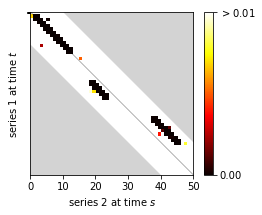

In [224]:
plt.figure(figsize=(4,3))
ldn.imshow(pval_est, cmap='hot', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

cbar = plt.colorbar(ticks=[0, 0.01])
cbar.ax.set_yticklabels(['0.00','$>$0.01'])
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

([<matplotlib.axis.YTick at 0x7fb2d835ee10>,
 <a list of 6 Text yticklabel objects>)

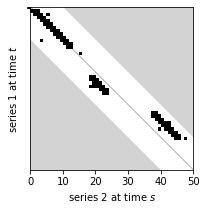

In [251]:
plt.figure(figsize=(3,3))
ldn.imshow(pval_est > 0.01, cmap='gray', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

# cbar = plt.colorbar(ticks=[0, 0.01])
# cbar.ax.set_yticklabels(['0.00','$>$0.01'])
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

Text(0, 0.5, 'series 1 at time $t$')

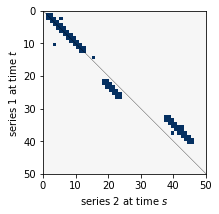

In [250]:
plt.figure(figsize=(3,3))
ldn.imshow(rej_BH * roi, time=rec_time, identity=True)
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")

([<matplotlib.axis.YTick at 0x7fb2d5379550>,
 <a list of 6 Text yticklabel objects>)

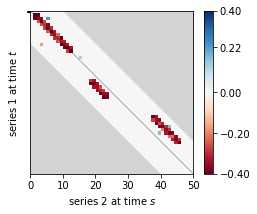

In [230]:
fig, ax = plt.subplots(figsize=(4,3))
ldn.imshow(rej_BH * dspr_est[:num_time,num_time:], time=rec_time, identity=True)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.clim(-0.4,0.4); cbar = plt.colorbar(ticks=[-0.4, -0.2, 0.0, 0.22, 0.4])
# cbar.ax.set_yticklabels(['-2e-3','-1e-3','0','1e-3','2e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

## excursion test

In [232]:
ths_nv = k_hat * alpha / np.sum(roi)

In [233]:
rej_nv = pval_est <= ths_nv
rejs_nv_perm = pvals_perm < ths_nv

In [234]:
rejs_blobs_perm = np.zeros((num_perm, num_time, num_time))
nums_blobs_perm = np.zeros((num_perm,))

for iter_perm in range(num_perm):
    mask_cp = rejs_nv_perm[iter_perm]; iter_blob = 0
    while np.any(mask_cp):
        iter_blob += 1
        queue = [tuple(np.transpose(np.where(mask_cp))[0])]
        mask_cp[queue[0]] = False
        while len(queue) > 0:
            cur = queue.pop(0)
            rejs_blobs_perm[iter_perm, cur[0], cur[1]] = iter_blob
            if cur[0] > 0:
                if mask_cp[cur[0]-1, cur[1]]:
                    queue.append((cur[0]-1, cur[1]))
                    mask_cp[cur[0]-1, cur[1]] = False
            if cur[0] < num_time-1:
                if mask_cp[cur[0]+1, cur[1]]:
                    queue.append((cur[0]+1, cur[1]))
                    mask_cp[cur[0]+1, cur[1]] = False
            if cur[1] > 0:
                if mask_cp[cur[0], cur[1]-1]:
                    queue.append((cur[0], cur[1]-1))
                    mask_cp[cur[0], cur[1]-1] = False
            if cur[1] < num_time-1:
                if mask_cp[cur[0], cur[1]+1]:
                    queue.append((cur[0], cur[1]+1))
                    mask_cp[cur[0], cur[1]+1] = False
    nums_blobs_perm[iter_perm] = iter_blob

In [235]:
mrois_nv_perm = np.zeros(num_perm)
for iter_perm, (pval, rej_b, num_b) \
in enumerate(zip(pvals_perm, rejs_blobs_perm, nums_blobs_perm)):
    rois = np.zeros(int(num_b+1))
    for iter_blob in range(1, int(num_b+1)):
        rois[iter_blob] = np.sum(-np.log(
            pvals_perm[iter_perm][rej_b == iter_blob]))
    mrois_nv_perm[iter_perm] = np.max(rois)

In [236]:
ths_roi = np.quantile(mrois_nv_perm, 0.95)

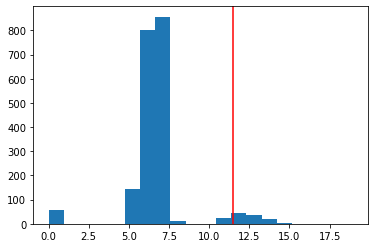

In [237]:
plt.hist(mrois_nv_perm, bins=20)
plt.axvline(x=ths_roi, color='red')

In [238]:
rej_blobs = np.zeros((num_time, num_time))

mask_cp = rej_nv; iter_blob = 0
while np.any(mask_cp):
    iter_blob += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        rej_blobs[cur[0], cur[1]] = iter_blob
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
num_blobs = iter_blob

In [239]:
rois_nv = np.zeros(num_blobs+1)
for iter_blob in range(1, num_blobs+1):
    rois_nv[iter_blob] = np.sum(-np.log(pval_est[rej_blobs == iter_blob]))

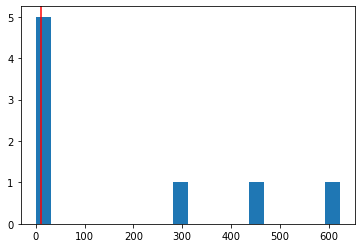

In [240]:
plt.hist(rois_nv, bins=20)
plt.axvline(x=ths_roi, color='red')

Text(0.5, 0, 'series 2 at time $s$')

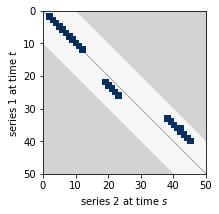

In [241]:
plt.figure(figsize=(3,3))
ldn.imshow(np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]), time=[rec_time[0], rec_time[1]], identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')


Text(0.5, 0, 'series 2 at time $s$')

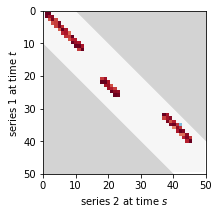

In [246]:
plt.figure(figsize=(3,3))
ldn.imshow(dspr_est[:num_time,num_time:] * np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]),
          vmax=0.4)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

In [243]:
np.mean(rois_nv <= mrois_nv_perm[:,None], 0)

array([1.   , 0.   , 0.064, 0.783, 0.97 , 0.   , 0.   , 0.927])